In [1]:
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Data splitting

In [2]:
dfall = pd.read_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/alldata.csv')
dfall['datetime'] = pd.to_datetime(dfall['datetime'])
dfall = dfall.sort_values('datetime').reset_index(drop=True)

df=dfall.copy()
df = df[['datetime', 'price']]

In [3]:
print(f"{len(df)} hrs")
print(f"from {df['datetime'].min()} -> {df['datetime'].max()}")

65785 hrs
from 2018-01-01 00:00:00 -> 2025-07-04 00:00:00


In [10]:
train_end = pd.Timestamp('2024-12-30 23:00:00')
val_end   = pd.Timestamp('2025-04-30 23:00:00')  




train = df[df['datetime'] <= train_end].copy()
val = df[(df['datetime'] > train_end) & (df['datetime'] <= val_end)].copy()
test = df[df['datetime'] > val_end].copy()

print(f"\n TRAIN")
print(f"period:{train['datetime'].min()} → {train['datetime'].max()}")
print(f"hrs: {len(train)} ({len(train)/24:.1f} jours)")
print(f"% total : {len(train)/len(df)*100:.1f}%")

print(f"\n VALIDATION")
print(f"period : {val['datetime'].min()} → {val['datetime'].max()}")
print(f"hrs: {len(val)} ({len(val)/24:.1f} jours)")
print(f"% total : {len(val)/len(df)*100:.1f}%")

print(f"\n TEST")
print(f"period : {test['datetime'].min()} → {test['datetime'].max()}")
print(f"hrs: {len(test)} ({len(test)/24:.1f} jours)")
print(f"%total : {len(test)/len(df)*100:.1f}%")


 TRAIN
period:2018-01-01 00:00:00 → 2024-12-30 23:00:00
hrs: 61344 (2556.0 jours)
% total : 93.2%

 VALIDATION
period : 2024-12-31 00:00:00 → 2025-04-30 23:00:00
hrs: 2904 (121.0 jours)
% total : 4.4%

 TEST
period : 2025-05-01 00:00:00 → 2025-07-04 00:00:00
hrs: 1537 (64.0 jours)
%total : 2.3%


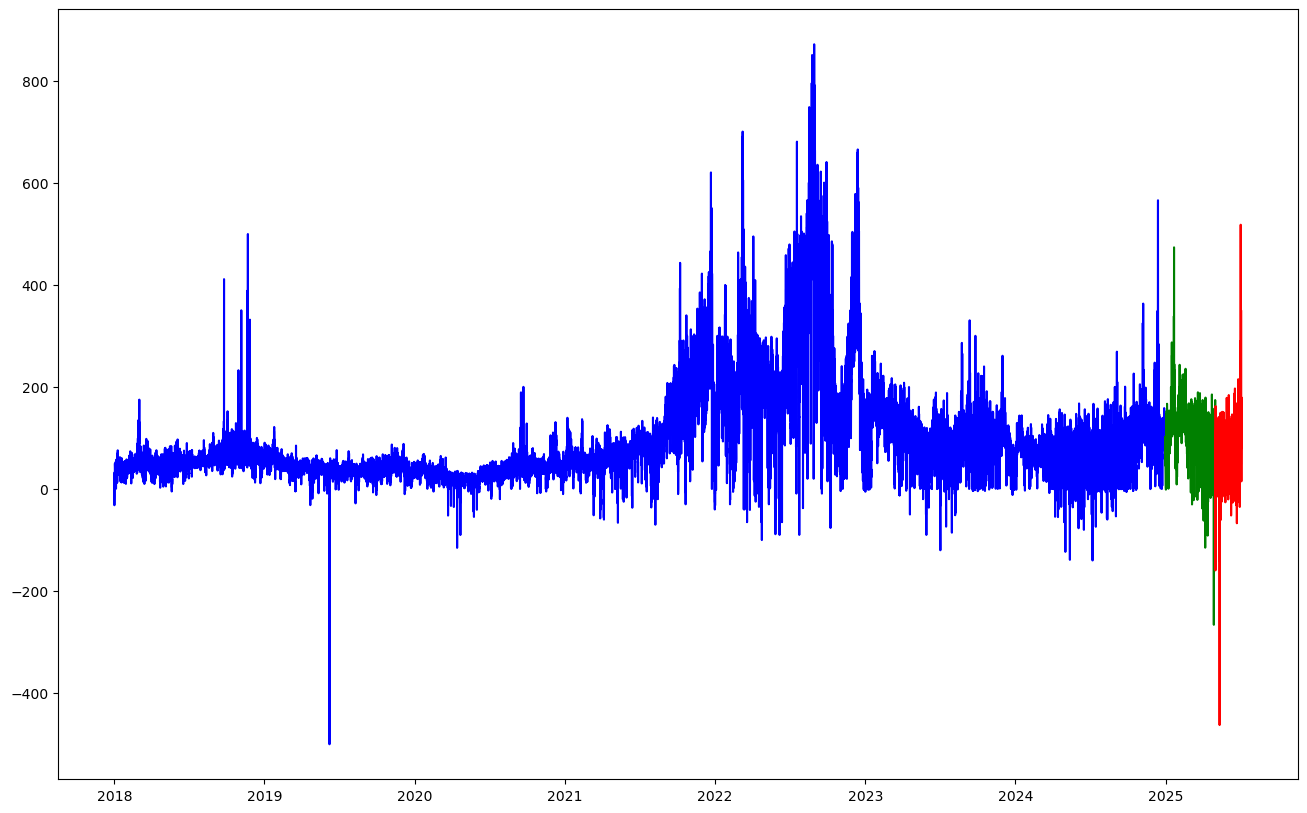

In [11]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(train['datetime'], train['price'],label="Train",
    color='blue')

ax.plot(val['datetime'], val['price'],label="Validation",
    color='green')

ax.plot(test['datetime'], test['price'],label="Test",
    color='red')

# Evaluation

In [6]:
def forecast_eval(y_true, y_pred, model_name="Model"):
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    
    y_true_clean= y_true[mask]
    y_pred_clean=y_pred[mask]
    mae = np.mean(np.abs(y_true_clean - y_pred_clean))
    rmse = np.sqrt(np.mean((y_true_clean - y_pred_clean)**2))
    mask_positive = y_true_clean > 1.0
    if mask_positive.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mask_positive] -y_pred_clean[mask_positive])/y_true_clean[mask_positive]))* 100
    else:
        mape = np.nan
    
    return {
        'model': model_name,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

# Naive models

## Basic J+1=J model

In [7]:
y_true=test['price'].values[24:]
y_pred=test['price'].shift(24).values[24:]


results_naive= forecast_eval(y_true,y_pred,"Naive J+1")
print(results_naive)

{'model': 'Naive J+1', 'mae': np.float64(25.805523329129883), 'rmse': np.float64(38.81646119590262), 'mape': np.float64(88.78754464526291)}


### "good" for a basic model !
    -> it is logical because prices evolve in the same direction every day
        -> Same direction, node amplitude !


## Basic Seasonal model (different lags)

In [8]:
for i in range(14):
    y_true_temp = test['price'].values[i*24:]
    y_pred_temp = test['price'].shift(i*24).values[i*24:]
    mae = np.mean(np.abs(y_true_temp - y_pred_temp))
    print(f"for {i} days lag, we have a mae of : {mae}")

for 0 days lag, we have a mae of : 0.0
for 1 days lag, we have a mae of : 25.805523329129883
for 2 days lag, we have a mae of : 29.77959687906372
for 3 days lag, we have a mae of : 30.8935033557047
for 4 days lag, we have a mae of : 31.99307905686546
for 5 days lag, we have a mae of : 28.444375896700148
for 6 days lag, we have a mae of : 28.150921248142645
for 7 days lag, we have a mae of : 29.32676425269646
for 8 days lag, we have a mae of : 32.186432
for 9 days lag, we have a mae of : 32.402678868552414
for 10 days lag, we have a mae of : 33.698682842287695
for 11 days lag, we have a mae of : 32.63056057866184
for 12 days lag, we have a mae of : 33.20844990548204
for 13 days lag, we have a mae of : 30.948039603960392


## ARIMA

In [9]:
#!pip install pmdarima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

#### we have a stationnary evolution 
            => d=0 

In [10]:
#p,d,q
order = (1, 0, 1)
predictions = []
actuals = []

for i in range(0, len(test), 24):
    if i + 24> len(test):
        break
    history = df[df['datetime'] <= test.iloc[i]['datetime']]['price'].values

    try:
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        
        
        forecast = model_fit.forecast(steps=24)

        predictions.extend(forecast)
        actuals.extend(test.iloc[i:i+24]['price'].values)
        if (i // 24) % 10 == 0:
            print(f"Jour {i//24 + 1}/{len(test)//24}...")
    
    except Exception as e:
        print(f"error at {i//24}: {str(e)[:50]}...")
        continue

print(f"\n{len(predictions)} predicted hrs")

y_true_arima = np.array(actuals)
y_pred_arima = np.array(predictions)

results_arima = forecast_eval(y_true_arima, y_pred_arima, "ARIMA(1,0,1)")
print(results_arima)

Jour 1/34...
Jour 11/34...
Jour 21/34...
Jour 31/34...

816 predicted hrs
{'model': 'ARIMA(1,0,1)', 'mae': np.float64(41.18008810004329), 'rmse': np.float64(58.98893327858539), 'mape': np.float64(208.79121868714395)}


## Results

In [11]:
results_summary = pd.DataFrame([
    results_naive,
    results_arima,
])


results_summary.to_csv('/Users/jeanvanbeneden/Documents/Projects/electricity-forecasting/Data/Processed/base_results.csv', index=False)

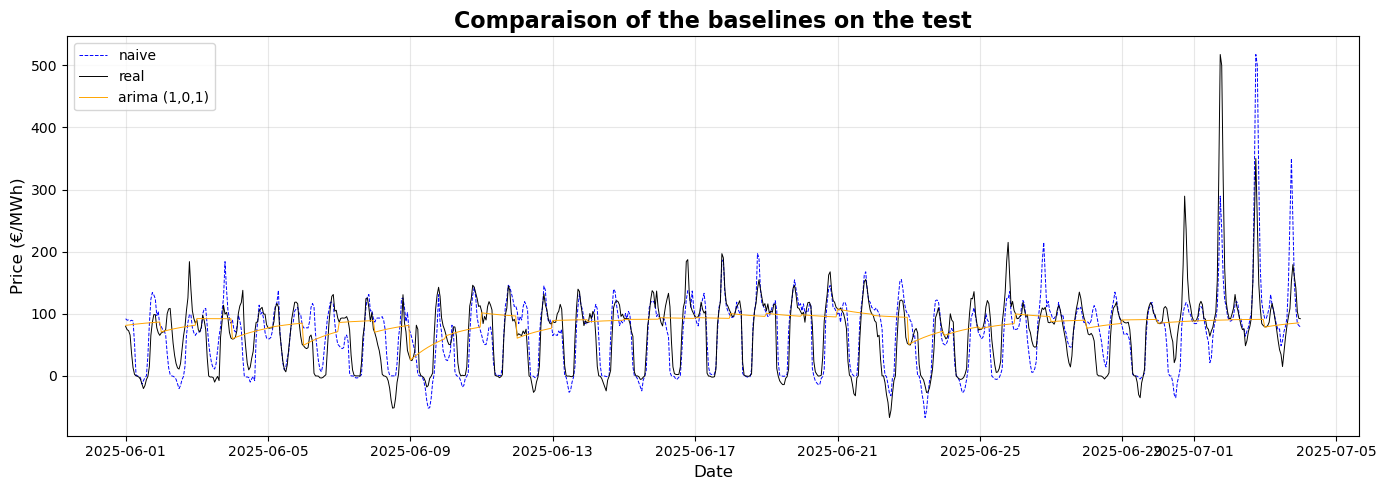

In [15]:
fig, ax = plt.subplots(figsize=(14, 5))

dates=test['datetime'].values[24:]

ax.plot(dates, y_pred, linestyle='--', linewidth=0.7, color='blue', label='naive')
ax.plot(dates, y_true, linewidth=0.7, color='black', label='real')
ax.plot(dates[:len(y_pred_arima[24:])], y_pred_arima[24:],linestyle='-', linewidth=0.7, color='orange', label='arima (1,0,1)')
ax.set_title('Comparaison of the baselines on the test', 
                  fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (€/MWh)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

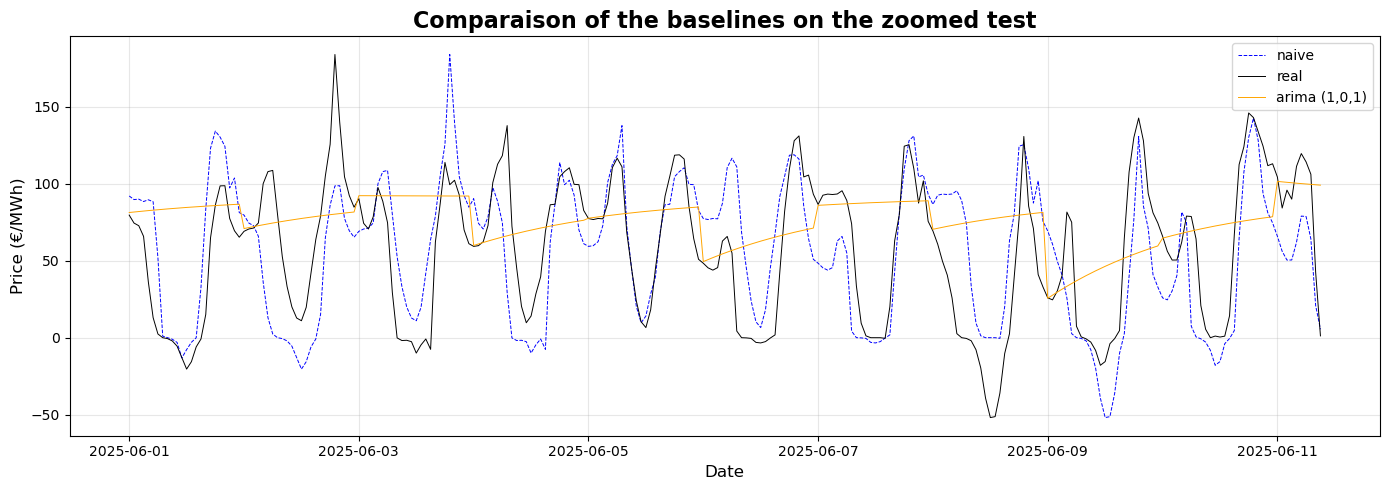

In [16]:
fig, ax = plt.subplots(figsize=(14, 5))

dates=test['datetime'].values[24:]

ax.plot(dates[:250], y_pred[:250], linestyle='--', linewidth=0.7, color='blue', label='naive')
ax.plot(dates[:250], y_true[:250], linewidth=0.7, color='black', label='real')
ax.plot(dates[:250], y_pred_arima[24:][:250],linestyle='-', linewidth=0.7, color='orange', label='arima (1,0,1)')
ax.set_title('Comparaison of the baselines on the zoomed test', 
                  fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (€/MWh)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()